# Setup

In [ ]:
!pip install jupysql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.3 MB/s eta 0:00:00


In [ ]:
%load_ext sql

In [ ]:
!wget https://rtvad.blob.core.windows.net/misc-data/northwind.sqlite3

--2023-07-09 19:56:52--  https://rtvad.blob.core.windows.net/misc-data/northwind.sqlite3
Resolving rtvad.blob.core.windows.net (rtvad.blob.core.windows.net)... 20.60.132.100
Connecting to rtvad.blob.core.windows.net (rtvad.blob.core.windows.net)|20.60.132.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 804864 (786K) [application/octet-stream]
Saving to: ‘northwind.sqlite3’

northwind.sqlite3   100%[===================>] 786.00K  4.47MB/s    in 0.2s    

2023-07-09 19:56:52 (4.47 MB/s) - ‘northwind.sqlite3’ saved [804864/804864]



In [ ]:
%sql sqlite:///northwind.sqlite3

# Modelagem atual

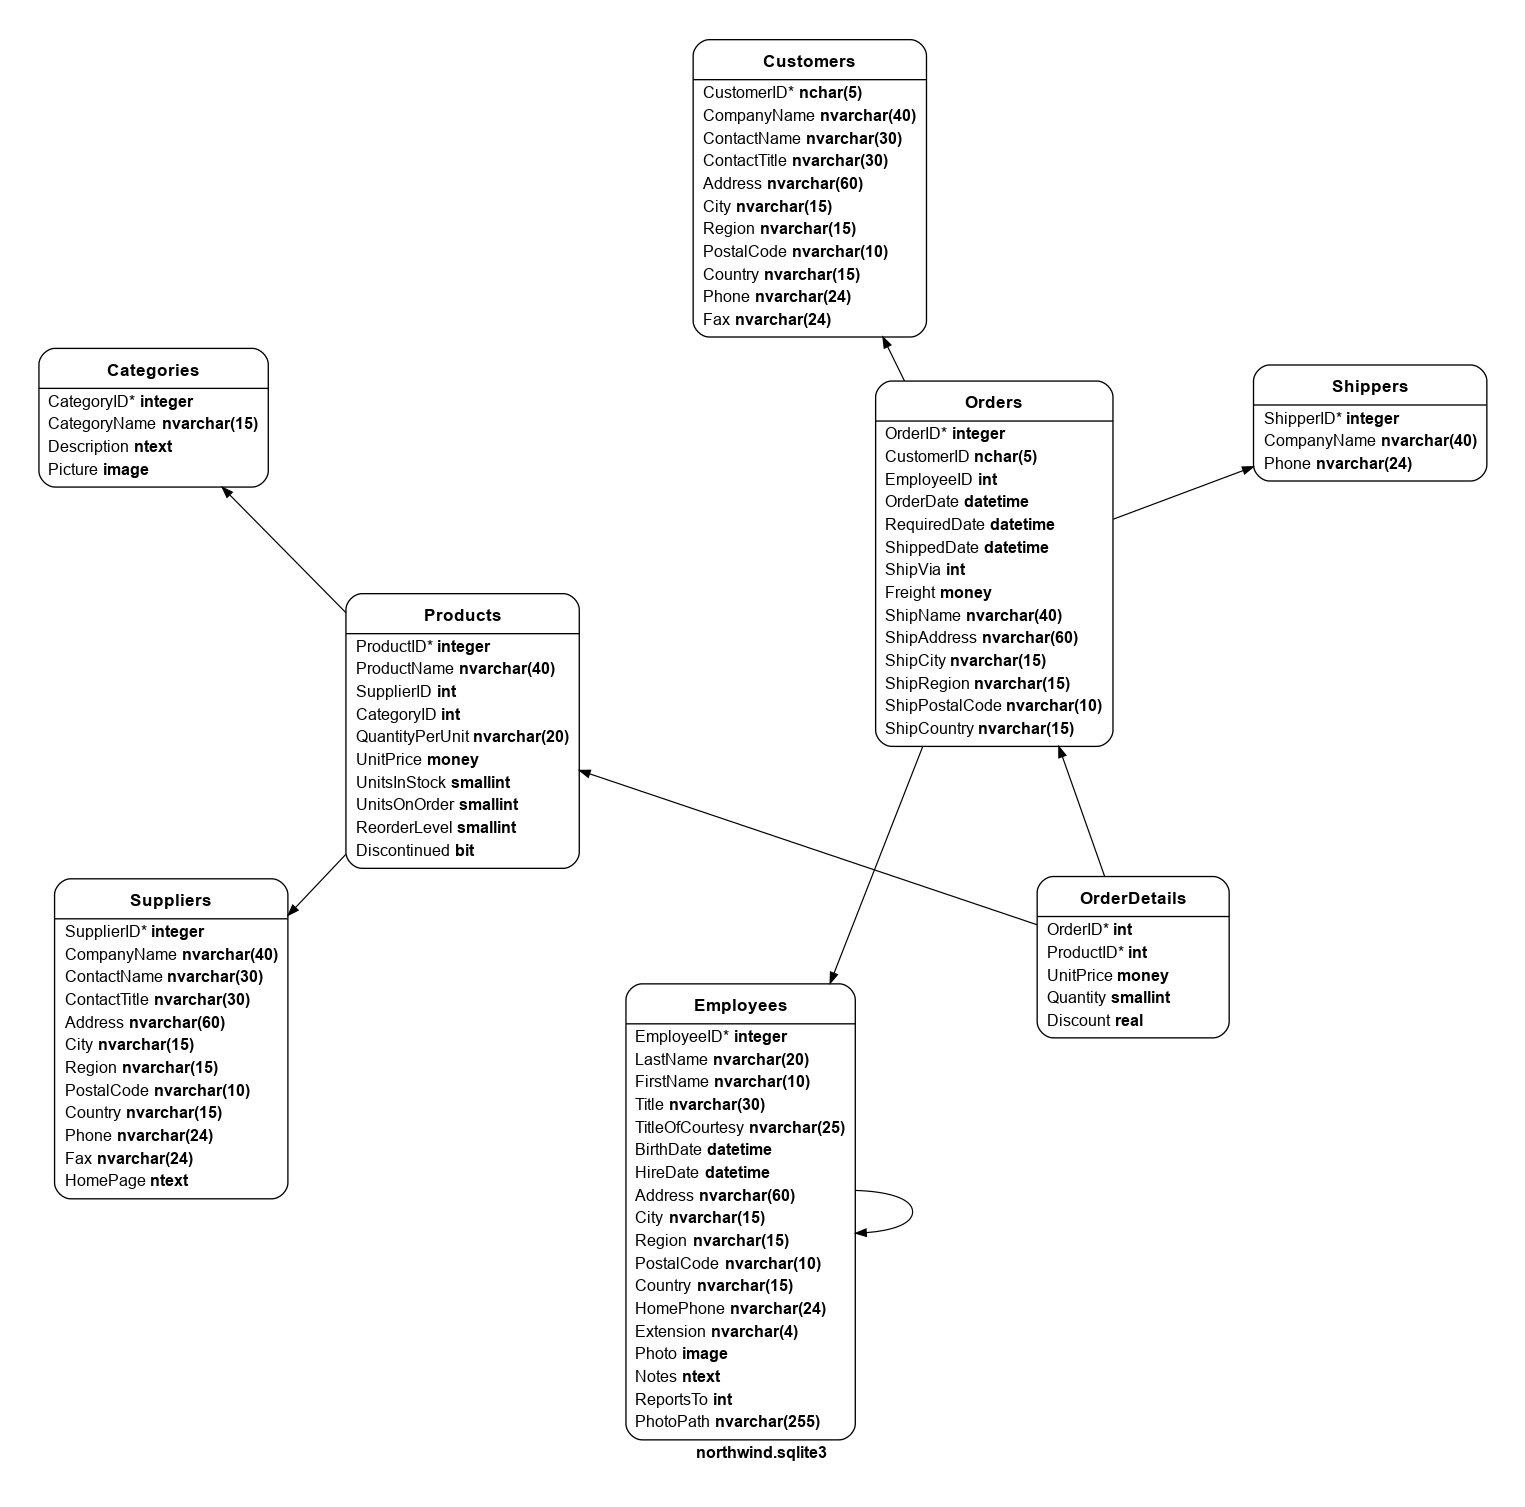

# Star Schema

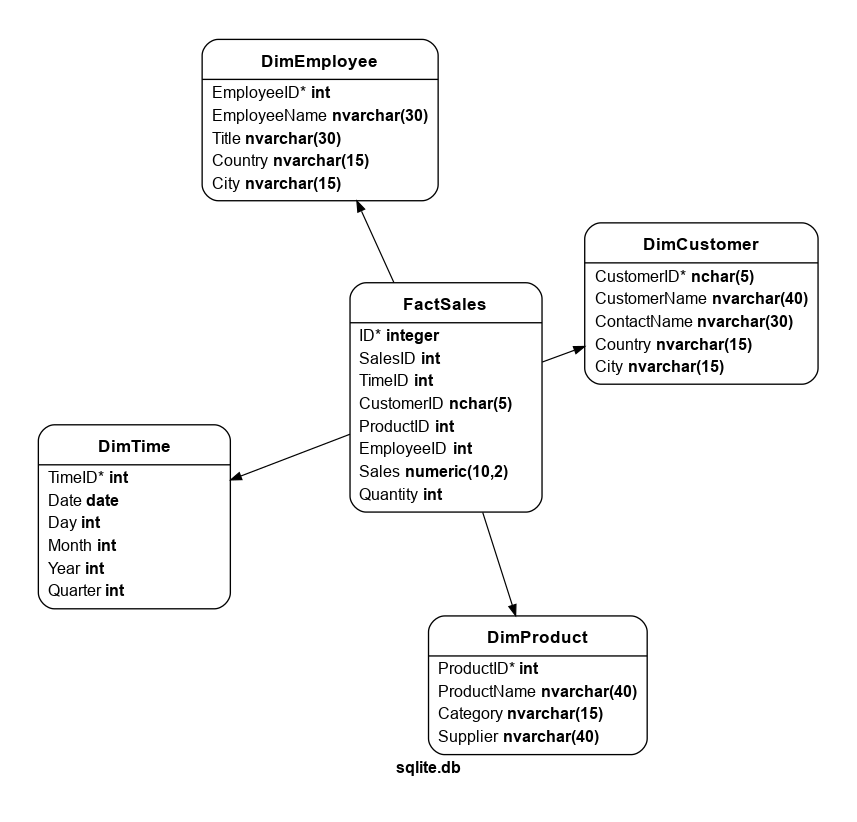

#Exercício

Neste exercício, vamos simular a transformação da base de dados Northwind para um modelo de dados dimensional. O objetivo é criar um modelo mais otimizado para análise e consulta de dados, conhecido como modelagem dimensional. Vamos fazer as seguintes atividades:

1. Identificar as entidades principais da base de dados:
   - Customers
   - Employees
   - Orders
   - OrderDetails
   - Products

2. Identificar as dimensões:
   - Dimensão de Tempo (Time)
   - Dimensão de Cliente (Customer)
   - Dimensão de Produto (Product)
   - Dimensão de Funcionário (Employee)

3. Identificar as medidas:
   - Medida de Venda (Sales)
   - Medida de Quantidade (Quantity)

4. Criar as tabelas de dimensão:
   - Tabela "Time" com as colunas: TimeID, Date, Day, Month, Year, Quarter
   - Tabela "Customer" com as colunas: CustomerID, CustomerName, ContactName, Country, City
   - Tabela "Product" com as colunas: ProductID, ProductName, Category, Supplier
   - Tabela "Employee" com as colunas: EmployeeID, EmployeeName, Title, Country, City

5. Criar a tabela de fatos (tabela central que une as dimensões e medidas):
   - Tabela "Sales" com as colunas: SalesID, TimeID, CustomerID, ProductID, EmployeeID, Sales, Quantity

6. Migrar e preencher os dados nas novas tabelas:
   - Para cada tabela de dimensão, migre e preencha os dados correspondentes, mantendo a integridade referencial com a tabela de fatos.
   - Para a tabela de fatos, migre e preencha os dados de vendas e quantidades correspondentes, atribuindo os IDs corretos das tabelas de dimensão.

Após realizar esses passos, a base de dados Northwind estará transformada em um modelo dimensional. Isso facilitará a análise e consulta dos dados, permitindo realizar pesquisas mais eficientes em relação aos aspectos temporais, hierárquicos e de relacionamento entre as dimensões e medidas.

Vamos lá?

## Passo 1: Criar as tabelas de dimensões

In [ ]:
%%sql

-- Tabela DimTime
CREATE TABLE DimTime (
  TimeID INT PRIMARY KEY,
  Date DATE,
  Day INT,
  Month INT,
  Year INT,
  Quarter INT
);

-- Tabela DimCustomer
CREATE TABLE DimCustomer (
  CustomerID NCHAR(5) PRIMARY KEY,
  CustomerName NVARCHAR(40),
  ContactName NVARCHAR(30),
  Country NVARCHAR(15),
  City NVARCHAR(15)
);

-- Tabela DimProduct
CREATE TABLE DimProduct (
  ProductID INT PRIMARY KEY,
  ProductName NVARCHAR(40),
  Category NVARCHAR(15),
  Supplier NVARCHAR(40)
);

-- Tabela DimEmployee
CREATE TABLE DimEmployee (
  EmployeeID INT PRIMARY KEY,
  EmployeeName NVARCHAR(30),
  Title NVARCHAR(30),
  Country NVARCHAR(15),
  City NVARCHAR(15)
);

Running query in 'sqlite:///northwind.sqlite3'

## Passo 2: Criar a tabela de fatos

In [ ]:
%%sql

-- Tabela FactSales
CREATE TABLE FactSales (
  ID INTEGER PRIMARY KEY AUTOINCREMENT,
  SalesID INT,
  TimeID INT,
  CustomerID NCHAR(5),
  ProductID INT,
  EmployeeID INT,
  Sales NUMERIC(10,2),
  Quantity INT,
  FOREIGN KEY (TimeID) REFERENCES DimTime(TimeID),
  FOREIGN KEY (CustomerID) REFERENCES DimCustomer(CustomerID),
  FOREIGN KEY (ProductID) REFERENCES DimProduct(ProductID),
  FOREIGN KEY (EmployeeID) REFERENCES DimEmployee(EmployeeID)
);

Running query in 'sqlite:///northwind.sqlite3'

## Passo 3: Inserir os dados nas tabelas de dimensões

In [ ]:
%%sql

-- Inserir dados na tabela DimTime
INSERT INTO DimTime (TimeID, Date, Day, Month, Year, Quarter)
SELECT OrderID, OrderDate, strftime('%d', OrderDate), strftime('%m', OrderDate), strftime('%Y', OrderDate), strftime('%m', OrderDate)
FROM Orders;

-- Inserir dados na tabela DimCustomer
INSERT INTO DimCustomer (CustomerID, CustomerName, ContactName, Country, City)
SELECT CustomerID, CompanyName, ContactName, Country, City
FROM Customers;

-- Inserir dados na tabela DimProduct
INSERT INTO DimProduct (ProductID, ProductName, Category, Supplier)
SELECT ProductID, ProductName, CategoryName, CompanyName
FROM Products
JOIN Categories ON Products.CategoryID = Categories.CategoryID
JOIN Suppliers ON Products.SupplierID = Suppliers.SupplierID;

-- Inserir dados na tabela DimEmployee
INSERT INTO DimEmployee (EmployeeID, EmployeeName, Title, Country, City)
SELECT EmployeeID, FirstName || ' ' || LastName, Title, Country, City
FROM Employees;

Running query in 'sqlite:///northwind.sqlite3'

830 rows affected.

91 rows affected.

77 rows affected.

9 rows affected.

## Passo 4: Migrar os dados para a tabela de fatos

In [ ]:
%%sql

INSERT INTO FactSales (SalesID, TimeID, CustomerID, ProductID, EmployeeID, Sales, Quantity)
SELECT o.OrderID, o.OrderID, o.CustomerID, od.ProductID, o.EmployeeID, (od.UnitPrice * od.Quantity) AS Sales, od.Quantity
FROM OrderDetails od
JOIN Orders o ON od.OrderID = o.OrderID;

Running query in 'sqlite:///northwind.sqlite3'

2155 rows affected.

## Passo 5: Realizar consultas nas tabelas dimensionais e tabela de fatos

In [ ]:
%%sql

-- Consulta 1: Total de vendas por categoria de produto
SELECT dp.Category, SUM(fs.Sales) AS TotalSales
FROM FactSales fs
JOIN DimProduct dp ON fs.ProductID = dp.ProductID
GROUP BY dp.Category;

Running query in 'sqlite:///northwind.sqlite3'

Category,TotalSales
Beverages,286660.15
Condiments,113694.75000000001
Confections,177352.71999999994
Dairy Products,251330.5
Grains/Cereals,100726.8
Meat/Poultry,178188.80000000002
Produce,105500.6
Seafood,141623.09000000003


In [ ]:
%%sql

-- Consulta 2: Clientes que fizeram mais pedidos
SELECT dc.CustomerName, COUNT(DISTINCT fs.SalesID) AS TotalOrders
FROM FactSales fs
JOIN DimCustomer dc ON fs.CustomerID = dc.CustomerID
GROUP BY dc.CustomerName
ORDER BY TotalOrders DESC
LIMIT 5;

Running query in 'sqlite:///northwind.sqlite3'

CustomerName,TotalOrders
Save-a-lot Markets,31
Ernst Handel,30
QUICK-Stop,28
Hungry Owl All-Night Grocers,19
Folk och fä HB,19
